# Workshop: Vectorized Backtesting & Alpha Generation
**Goal:** Build a Mean-Reversion strategy from scratch. We will use Pandas for signal generation and pure NumPy for high-performance backtesting.

In [2]:
#main imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for data
import yfinance as yf

#plotting config
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 7)

## 1. Getting the Data
Lets pull some data that experiences trends and fluctuations, so that we can see the mean and its deviations.

In [3]:
#fetch data
ticker = 'SPY'
df = yf.download(ticker, start='2021-01-01', end='2026-01-01')

#to fix the multi index columns
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

#get close prices
df = df[['Close']].copy()

#inspect data
display(df.head())
df.info()

/tmp/ipython-input-3641946628.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start='2021-01-01', end='2026-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2021-01-04,344.256744
2021-01-05,346.627777
2021-01-06,348.700104
2021-01-07,353.880920
2021-01-08,355.897186


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2021-01-04 to 2025-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1255 non-null   float64
dtypes: float64(1)
memory usage: 19.6 KB


## 2. Making Signals with Pandas (Bollinger Bands / Z-Score)
We are going to build a Z-Score indicator. This tells us how many standard deviations the current price is away from its rolling mean.
* **Assumption:** The price will eventually revert to its historical mean.

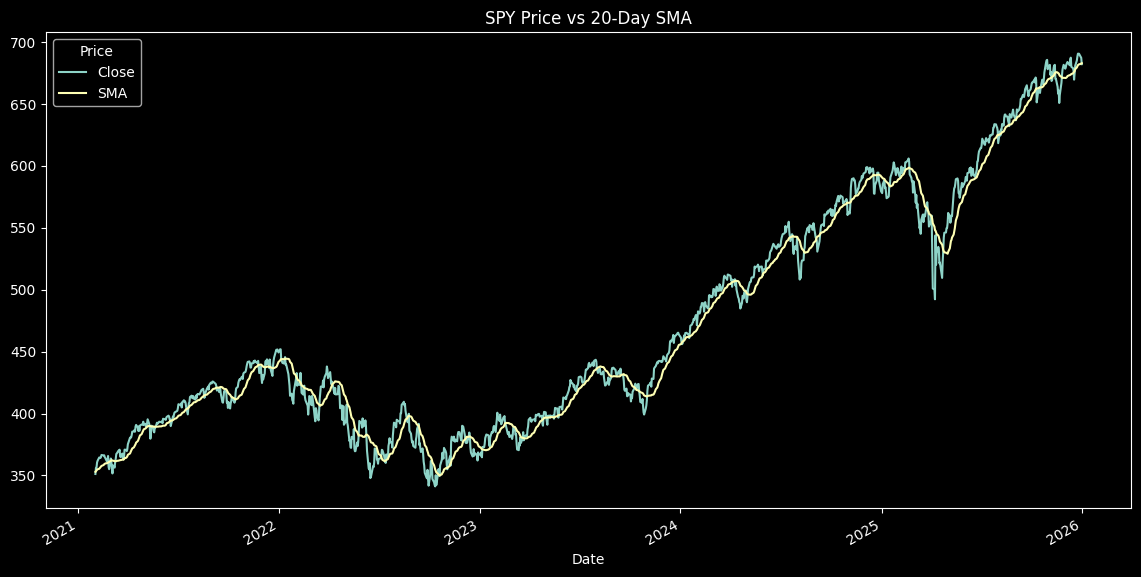

In [4]:
window = 20 #arbitrary rolling window

#we should use .rolling rather than a loop
#fix the code below
df['SMA'] = np.nan
df['Rolling_Std'] = np.nan

for i in range(window - 1, len(df)):
    df.loc[df.index[i], 'SMA'] = df['Close'].iloc[i - window + 1 : i + 1].mean()
    df.loc[df.index[i], 'Rolling_Std'] = df['Close'].iloc[i - window + 1 : i + 1].std()

#calculate z score (close - mean) / std
df['Z_Score'] = (df['Close'] - df['SMA']) / df['Rolling_Std']

#drop garbage values
df.dropna(inplace=True)

df[['Close', 'SMA']].plot(title=f'{ticker} Price vs {window}-Day SMA')
plt.show()

## 3. Making Trades (Avoiding Look-Ahead Bias)
Now we define our logic:
* **Go Long (+1):** If Z-Score < -2 (Oversold)
* **Go Short (-1):** If Z-Score > 2 (Overbought)
* **Flat (0):** Otherwise

**CRITICAL RULE:** If we calculate our signal using today's `Close` price, we cannot execute our trade *at* today's `Close` price. That creates data leakage (peeking into the future). We must execute tomorrow. We simulate this by shifting our position vector forward by 1.

In [5]:
#np.where(condition, value_if_true, value_if_false) is good for making masks
#we can nest them to handle Long, Short, and Flat states
#we want to have (1, -1, 0) for (Long, Short, Flat)
#consider what np.where(condition1, np.where(condition2, val1, val2), val3) does

df['Signal'] = np.where(df['Z_Score'] > 2, 1, np.where(df['Z_Score'] < -2, -1, 0))

#shift the signal to create the trade (hint, .shift())
df['Position'] = df['Signal'].shift(1)

#normally we forward fill to hold until next signal (hint, .ffill())
df['Position'] = df['Position'].ffill()

#drop the first row since it's NaN
df.dropna(inplace=True)

print(df['Position'].value_counts())

Position
 0.0    1117
-1.0      59
 1.0      59
Name: count, dtype: int64


## 4. Vectorized Backtesting with NumPy
Pandas is great for aligning data, but NumPy arrays are stored in contiguous blocks of memory, making mathematical operations lightning fast. We will extract our columns to raw NumPy arrays (`.values`) to calculate PnL.

In [15]:
#calculate the market returns (we do this wth log returns)
#you could alternatively do this as the diff/current, but then adjust the cumulative returns later
market_returns = np.log(df['Close'] / df['Close'].shift(1))

#get our positions from earilier
positions = df['Position'].values

#we can very quickly backtest by just multiplying our positions by the market returns
#consider is as the movement in the market weighted by exposure to the market
#hint, its very very simple in syntax
strategy_returns = positions * market_returns

#then we can just sum up all those little movements and exponentiate to get back the value
#if earlier you took diff/current, then how would you get back the returns?
#also do this for market returns, which is same as a position of 1 all the time
cum_market_returns = np.exp(np.cumsum(market_returns))
cum_strategy_returns = np.exp(np.cumsum(strategy_returns))

#lets calculate the sharpe ratio (assuming 252 trading days)
#sharpe = (mean return / volatility) * sqrt(252)
#hint, .mean() and .std()
sharpe_ratio = (np.mean(strategy_returns) / np.std(strategy_returns)) * np.sqrt(252)

print(f"Strategy Annualized Sharpe Ratio: {sharpe_ratio:.2f}")

Strategy Annualized Sharpe Ratio: -0.36


## 5. Visualizing the Equity Curve
Lets plot the equity value to see how we did.

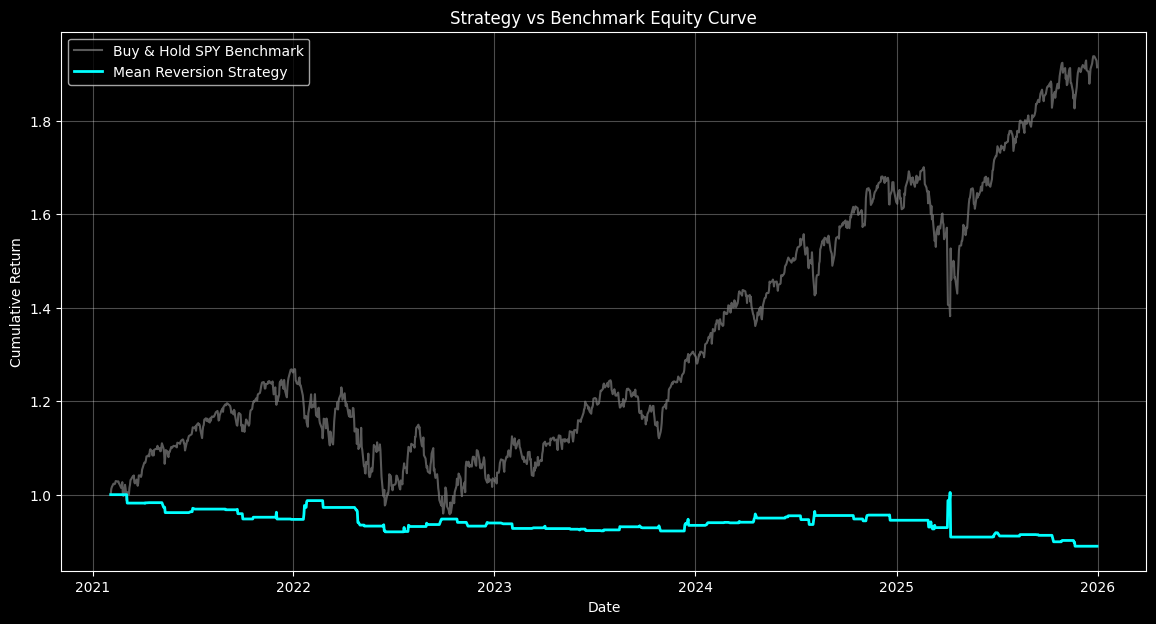

In [16]:
plt.figure(figsize=(14, 7))

#we need to pass in the index to accurately plot the dates
plt.plot(df.index, cum_market_returns, label='Buy & Hold SPY Benchmark', color='gray', alpha=0.7)
plt.plot(df.index, cum_strategy_returns, label='Mean Reversion Strategy', color='cyan', linewidth=2)

plt.title('Strategy vs Benchmark Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()